In [751]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [609]:
# Readind the csv dataset
full_data = pd.read_csv('data/diabetic_data.csv')

In [610]:
# Getting the first encounter (by min encounter_id per patient)
first_encounter_per_patient = full_data.groupby('patient_nbr').encounter_id.agg('min')
first_encounter = full_data.loc[full_data.encounter_id.isin(first_encounter_per_patient)]
first_encounter

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,443842016,183087545,Caucasian,Female,[70-80),?,1,1,7,9,...,No,Steady,No,No,No,No,No,Ch,Yes,>30
101755,443842022,188574944,Other,Female,[40-50),?,1,1,7,14,...,No,Up,No,No,No,No,No,Ch,Yes,>30
101756,443842070,140199494,Other,Female,[60-70),?,1,1,7,2,...,No,Steady,No,No,No,No,No,No,Yes,>30
101758,443842340,120975314,Caucasian,Female,[80-90),?,1,1,7,5,...,No,Up,No,No,No,No,No,Ch,Yes,NO


In [611]:
# Auxiliary function to create a dataframe with the icd9 codes as id's of Group Name os the diagnostics
def create_diag_name_dataframe(diagnostic_name, lower_bound, upper_bound):
    df = pd.concat([pd.DataFrame([diagnostic_name], index=[id], columns=['Group name']) 
                    for id in range(lower_bound,upper_bound+1)])
    return df

In [612]:
# Creates a unique dataframe with all diagnosis group names according to the Table 2 of the paper

# Circulatory group
circulatory = create_diag_name_dataframe('Circulatory',390,459)
circulatory = pd.concat([circulatory,create_diag_name_dataframe('Circulatory',785,785)])
# Respiratory group
respiratory = create_diag_name_dataframe('Respiratory',460,519)
respiratory = pd.concat([respiratory,create_diag_name_dataframe('Respiratory',786,786)])
# Digestive group
digestive = create_diag_name_dataframe('Digestive',520,579)
digestive = pd.concat([digestive,create_diag_name_dataframe('Digestive',787,787)])
# Diabetes group
diabetes = create_diag_name_dataframe('Diabetes',250,250)
# Injury group
injury = create_diag_name_dataframe('Injury',800,999)
# Musculoskeletal group
musculoskeletal = create_diag_name_dataframe('Musculoskeletal',710,739)
# Genitourinary group
genitourinary = create_diag_name_dataframe('Genitourinary',580,629)
genitourinary = pd.concat([genitourinary,create_diag_name_dataframe('Genitourinary',788,788)])
# Neoplasms group
neoplasms = create_diag_name_dataframe('Neoplasms',140,239)
neoplasms = pd.concat([neoplasms,create_diag_name_dataframe('Neoplasms',780,781)])
neoplasms = pd.concat([neoplasms,create_diag_name_dataframe('Neoplasms',784,784)])
neoplasms = pd.concat([neoplasms,create_diag_name_dataframe('Neoplasms',790,799)])
neoplasms = pd.concat([neoplasms,create_diag_name_dataframe('Neoplasms',240,249)])
neoplasms = pd.concat([neoplasms,create_diag_name_dataframe('Neoplasms',251,279)])
neoplasms = pd.concat([neoplasms,create_diag_name_dataframe('Neoplasms',680,709)])
neoplasms = pd.concat([neoplasms,create_diag_name_dataframe('Neoplasms',782,782)])
neoplasms = pd.concat([neoplasms,create_diag_name_dataframe('Neoplasms',1,139)])
# Other group
other = pd.DataFrame('Other', index=[0], columns=['Group name'])

diagnosis_names = pd.concat([circulatory,respiratory,digestive,
                             diabetes,injury,musculoskeletal,
                             genitourinary,neoplasms,other])

In [613]:
# Converts diagnostic codes' columns into number to join further
diag_number = pd.DataFrame(index=first_encounter.encounter_id)
diag_columns = ['diag_1', 'diag_2', 'diag_3']

for col in diag_columns:
    num_codes = []
    for v in first_encounter[col]:
        try:
            value = v.split('.')
            num_codes.append(int(value[0]))
        except:
            num_codes.append(int(0))
    diag_number[col] = num_codes

In [614]:
# Joins the original dataset with converted diagnostic codes' columns 
left = first_encounter.set_index(['encounter_id'])
right = diag_number

encounter_x_diag_numbers = left.join(right, rsuffix='_num')

In [615]:
# Adds the Group Names' of diagnostics to the original dataset
aux_df = encounter_x_diag_numbers

for col in diag_columns:
    left = aux_df.set_index(col + '_num')
    right = diagnosis_names.rename(columns={'Group name': 'Group_' + col})
    aux_df = left.join(right, rsuffix=col)
    
indexed_data = aux_df.set_index(encounter_x_diag_numbers.index)

# Since the data now have the diagnostic codes as numbers and theirs group names, the original columns are unnecessary
#indexed_data = indexed_data.drop(columns = diag_columns)
indexed_data

,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,Group_diag_1,Group_diag_2,Group_diag_3
encounter_id,,,,,,,,,,,,,,,,,,,,,
2278392,105325407,Caucasian,Male,[80-90),?,3,6,4,2,?,...,No,No,No,No,No,Yes,>30,Other,Other,Other
149190,39728214,?,Female,[70-80),?,2,1,1,7,?,...,No,No,No,No,No,No,>30,Other,Other,Other
64410,73761084,Caucasian,Female,[80-90),?,3,6,4,3,?,...,No,No,No,No,Ch,Yes,>30,Other,Other,Other
500364,86468616,Caucasian,Female,[70-80),?,3,1,1,10,?,...,No,No,No,No,No,Yes,>30,Other,Other,Other
16680,55461366,AfricanAmerican,Female,[70-80),?,2,1,1,7,?,...,No,No,No,No,Ch,Yes,NO,Other,Other,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443842016,122136422,Caucasian,Male,[50-60),?,2,3,1,7,MC,...,No,No,No,No,Ch,Yes,NO,Diabetes,Musculoskeletal,Injury
443842022,74125260,?,Male,[60-70),?,2,1,4,2,?,...,No,No,No,No,Ch,Yes,NO,Circulatory,Injury,Injury
443842070,19844505,Caucasian,Female,[50-60),?,3,6,1,8,PO,...,No,No,No,No,No,No,NO,Neoplasms,Injury,Injury


In [616]:
indexed_data.columns

Index(['patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'Group_diag_1', 'Group_diag_2', 'Group_diag_3'],
      dtype='object')

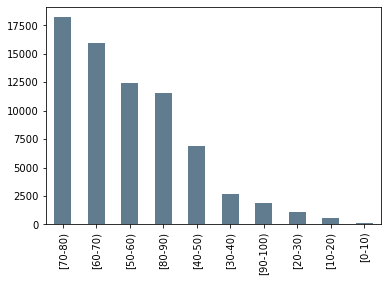

In [617]:
indexed_data.age.value_counts().plot(kind='bar',grid=False, color='#607c8e')

In [620]:
# Defines a function that return columns having a given char and the % the char appears on the data
def columns_have_char(df, char):
    columns_with_char = {}
    
    for col in df.columns:
        string_col = df[col].astype(str)
        number_of_observations = sum(string_col == char)
        
        if number_of_observations > 0:
            columns_with_char[col] = "{:.2%}".format(number_of_observations / df[col].count())
        
    return columns_with_char

In [621]:
# Exams the dataset seeking for missing values defined as "?"
list_col = columns_have_char(indexed_data,'?')
list_col

{'race': '2.72%',
 'weight': '96.01%',
 'payer_code': '43.41%',
 'medical_specialty': '48.21%',
 'diag_1': '0.02%',
 'diag_2': '0.41%',
 'diag_3': '1.71%'}

In [622]:
# Two possible actions were considered for each column in "list_col":
# 1) Fill mising values with "unknown" or "other";
# 2) Drop the column.

# After handling, the resulting dataset will be stored on 'final_df'
final_df = indexed_data

In [623]:
# 'race', 'diag_1', 'diag_2' and 'diag_3' columns have a 'Other' category, so action 1 for all
for col in ['race', 'diag_1', 'diag_2', 'diag_3']:
    final_df.loc[final_df[col] == '?', col] = 'Other'

# 'weight', 'payer_code' and 'medical_specialty' have too many missing values, so action 2
final_df = final_df.drop(columns=['weight', 'medical_specialty', 'payer_code'])

In [638]:
# Defines a functions that check if unique values of all columns are less than some number
def check_unique_values(df,unique_values_number):
    
    result_columns = {}
    
    for col in df.columns:
        unique_values_count = len(df[col].unique())
        
        if unique_values_count <= unique_values_number:
            result_columns[col] = unique_values_count
        
    return result_columns

In [651]:
# Checking for 4 categories
check_unique_values(final_df, 4)

{'gender': 3,
 'max_glu_serum': 4,
 'A1Cresult': 4,
 'metformin': 4,
 'repaglinide': 4,
 'nateglinide': 4,
 'chlorpropamide': 4,
 'glimepiride': 4,
 'acetohexamide': 2,
 'glipizide': 4,
 'glyburide': 4,
 'tolbutamide': 2,
 'pioglitazone': 4,
 'rosiglitazone': 4,
 'acarbose': 3,
 'miglitol': 4,
 'troglitazone': 2,
 'tolazamide': 2,
 'examide': 1,
 'citoglipton': 1,
 'insulin': 4,
 'glyburide-metformin': 4,
 'glipizide-metformin': 2,
 'glimepiride-pioglitazone': 1,
 'metformin-rosiglitazone': 2,
 'metformin-pioglitazone': 2,
 'change': 2,
 'diabetesMed': 2,
 'readmitted': 3}

In [657]:
# Removing columns with only one category
columns_to_drop = check_unique_values(final_df, 1).keys()
final_df = final_df.drop(columns=columns_to_drop)

In [756]:
# Defines a function to check for skewed data given a percentual
def skewed_columns(df, percentual):
    cols_with_skewed_data = []
    
    for col in df.columns:
        value_count = df[col].value_counts() / df[col].count()
        if value_count.max() >= percentual:
            cols_with_skewed_data.append(col)
            
    return cols_with_skewed_data

In [765]:
# Listing columns to plot for visual inspection
#worth_check = check_unique_values(final_df, 4)
#list_keys = list(worth_check.keys())
list_keys = skewed_columns(final_df, 0.75)
list_keys

['number_outpatient',
 'number_emergency',
 'number_inpatient',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'glyburide-metformin',
 'glipizide-metformin',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'diabetesMed']

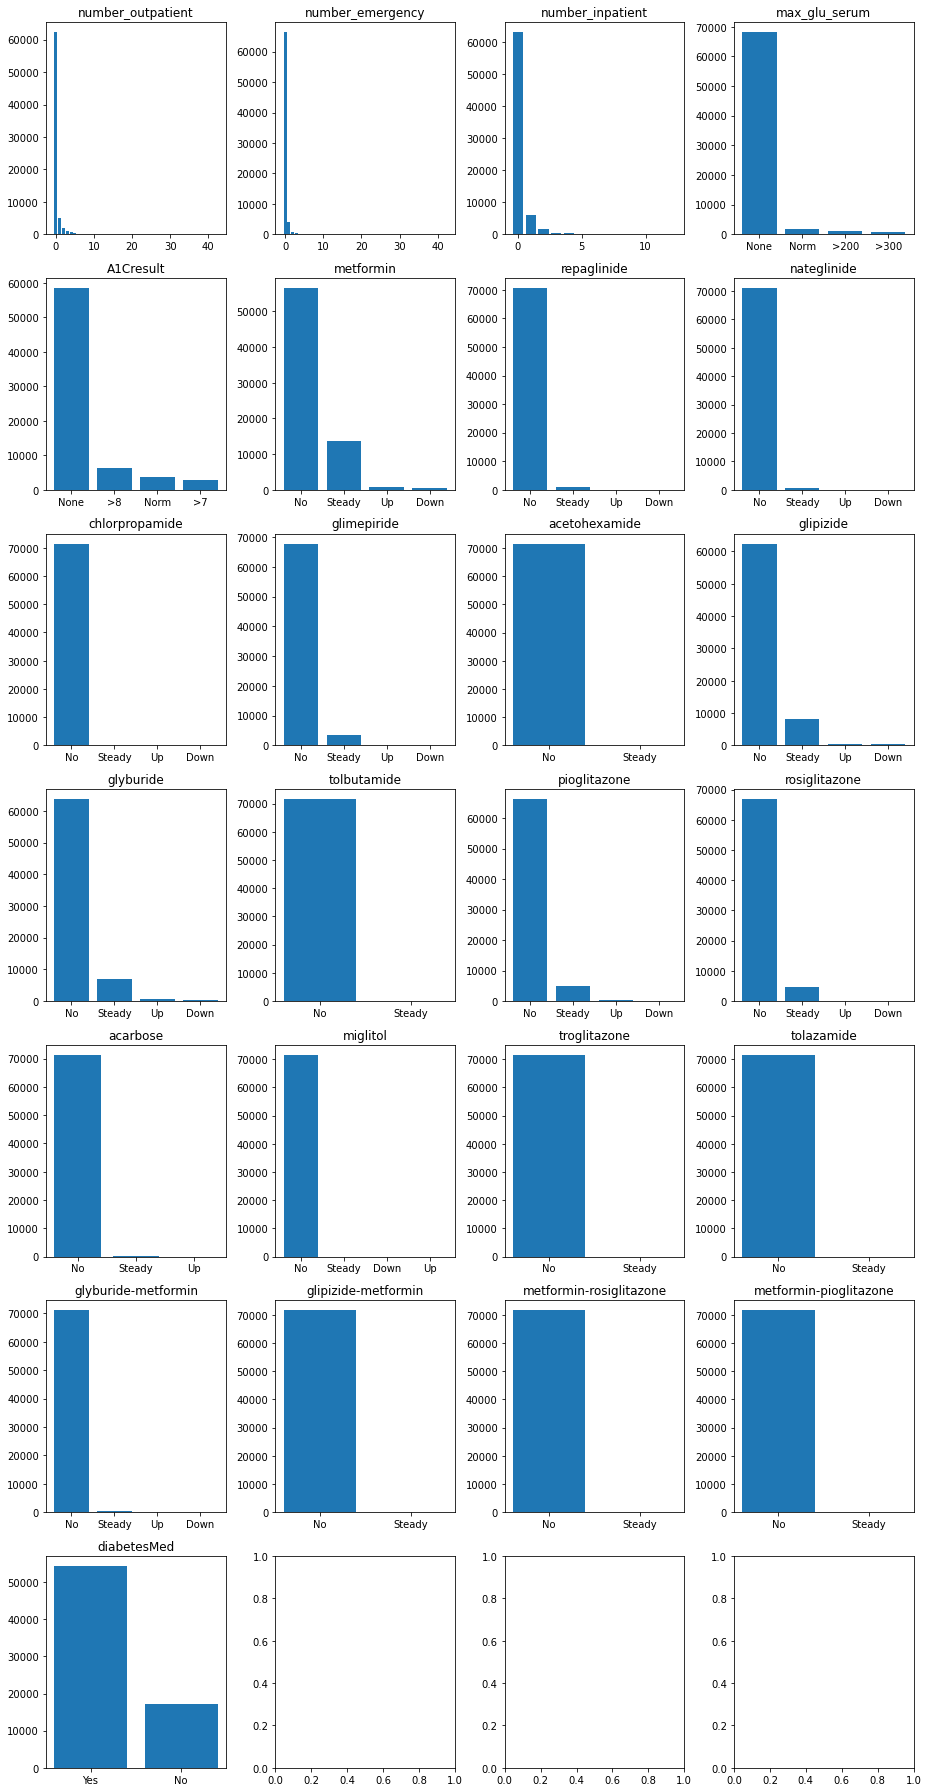

In [766]:
# Plots bar charts for columns selected before
n_cols = 4
n_rows = math.ceil(len(list_keys)/n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=[13,25])

for i in range(0, n_rows):
    for j in range(0, n_cols):
        key = (n_cols * i) + j
        if key < len(list_keys):
            g = final_df[list_keys[key]].value_counts()
            names = list(g.keys())
            values = list(g.values)

            axs[i, j].bar(names, values)
            axs[i, j].set_title(list_keys[key])

plt.tight_layout()
plt.show()

In [ ]:
# Decidir colunas to_drop e to_transform (tentar equilibrar o dataset)

In [733]:
to_drop = ['number_outpatient',
         'number_emergency',
         'number_inpatient',
         'max_glu_serum',
         'A1Cresult',
         'metformin',
         'repaglinide',
         'nateglinide',
         'chlorpropamide',
         'glimepiride',
         'acetohexamide',
         'glipizide',
         'glyburide',
         'tolbutamide',
         'pioglitazone',
         'rosiglitazone',
         'acarbose',
         'miglitol',
         'troglitazone',
         'tolazamide',
         'glyburide-metformin',
         'glipizide-metformin',
         'metformin-rosiglitazone',
         'metformin-pioglitazone',
         'diabetesMed']

In [ ]:
indexed_data.age.value_counts().plot(kind='bar',grid=False, color='#607c8e')

In [662]:
final_df['acetohexamide'].value_counts()

No        71517
Steady        1
Name: acetohexamide, dtype: int64

In [658]:
final_df.describe()

,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,7.151800e+04,71518.000000,71518.000000,71518.000000,71518.00000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000
mean,5.505160e+07,2.100254,3.593235,5.657457,4.28913,43.075478,1.430577,15.705025,0.280069,0.103540,0.177829,7.245700
std,3.947573e+07,1.508301,5.269771,4.162580,2.94921,19.952338,1.759864,8.311163,1.068957,0.509187,0.603790,1.994674
min,1.350000e+02,1.000000,1.000000,1.000000,1.00000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2.337577e+07,1.000000,1.000000,1.000000,2.00000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,4.816680e+07,1.000000,1.000000,7.000000,3.00000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,8.000000
75%,8.752222e+07,3.000000,3.000000,7.000000,6.00000,57.000000,2.000000,20.000000,0.000000,0.000000,0.000000,9.000000
max,1.895026e+08,8.000000,28.000000,25.000000,14.00000,132.000000,6.000000,81.000000,42.000000,42.000000,12.000000,16.000000


In [249]:
full_data.columns.sort_values(ascending=True)

Index(['A1Cresult', 'acarbose', 'acetohexamide', 'admission_source_id',
       'admission_type_id', 'age', 'change', 'chlorpropamide', 'citoglipton',
       'diabetesMed', 'diag_1', 'diag_2', 'diag_3', 'discharge_disposition_id',
       'encounter_id', 'examide', 'gender', 'glimepiride',
       'glimepiride-pioglitazone', 'glipizide', 'glipizide-metformin',
       'glyburide', 'glyburide-metformin', 'insulin', 'max_glu_serum',
       'medical_specialty', 'metformin', 'metformin-pioglitazone',
       'metformin-rosiglitazone', 'miglitol', 'nateglinide',
       'num_lab_procedures', 'num_medications', 'num_procedures',
       'number_diagnoses', 'number_emergency', 'number_inpatient',
       'number_outpatient', 'patient_nbr', 'payer_code', 'pioglitazone',
       'race', 'readmitted', 'repaglinide', 'rosiglitazone',
       'time_in_hospital', 'tolazamide', 'tolbutamide', 'troglitazone',
       'weight'],
      dtype='object')